In [34]:
setwd("C://Doc/19spring/STAT628/Module1")
rm(list=ls())


#data cleaning
BodyFat = read.table("BodyFat.csv", sep = ",", header = T)
BodyFat = BodyFat[,-1]
BodyFat = BodyFat[,-2]
BodyFat$HEIGHT[42] <- 69.5
BodyFat$WEIGHT[221] <- 173.25
BodyFat$WEIGHT[163] <- 164.25
BodyFat <- BodyFat[-c(182,172,39),]

Since Lasso regression penalize the coeeficients with the same regulization. We need to regulize the features first. Lasso can eliminate the muticollinearity in a certain degree. However, it cannot tackle with the collinearity between authentic and noisy variables.$^{[1]}$ Thus we pick some variables according to our background research. We check the VIF and correlation of the selected variables. They donot have serious collinearity.<br>
Then we split the data into two parts. It can help us to choose a better $\lambda$.

[1] "The VIF of the selected variables are:"


AGE  ABDOMEN   HEIGHT     KNEE    THIGH    ANKLE   BICEPS  FOREARM 
2.084130 3.653023 1.691603 4.165023 5.260288 1.713773 3.024339 2.219261 
   WRIST 
2.609564

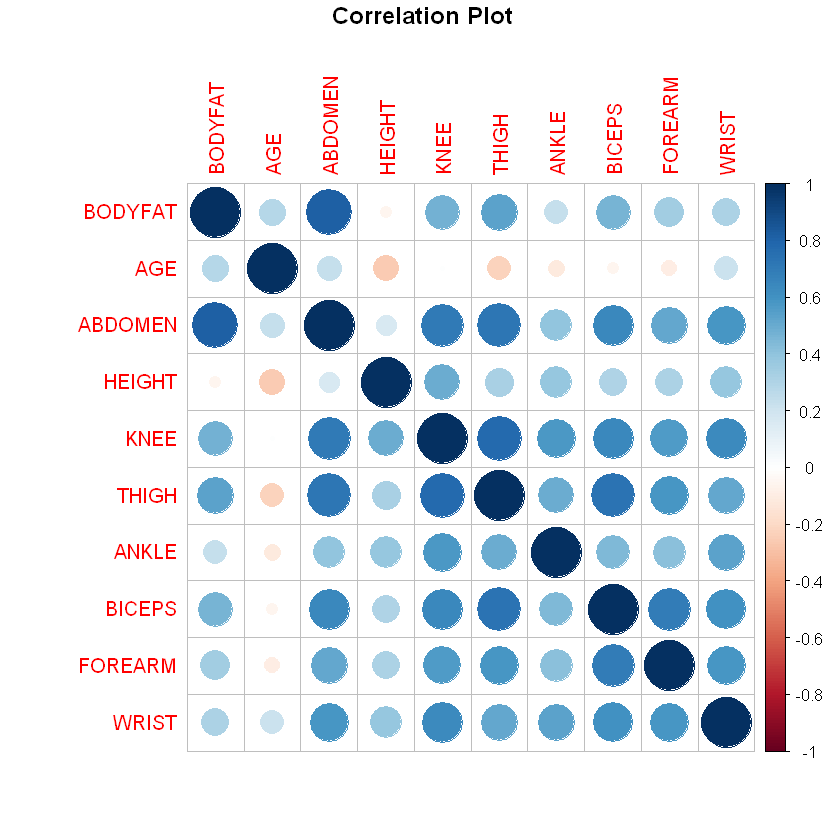

In [35]:
if(!require(plotmo)){
    install.package("plotmo")
}
if(!require(glmnet)){
    install.package("glmnet")
}
if(!require(corrplot)){
    install.package("corrplot")
}
require(plotmo)
require(corrplot)
require(glmnet)
#LASSO normalization
normalization <- function(datafr){
  if(ncol(datafr) > 1){
    new_dt <- as.data.frame(sapply(1:ncol(datafr), FUN = function(x)
      (datafr[,x]-min(datafr[,x]))/(max(datafr[,x]-min(datafr[,x])))))
    names(new_dt) <- names(datafr)
    return(new_dt)
  }else{
    return((datafr-min(datafr))/(max(datafr)-min(datafr)))
  }
}
unnormalization <- function(data_norm, data_raw){
  ###data_norm is the data before normalization, data_raw is the data after normalization
  if(ncol(data_raw) == 1){
    data_trans <- data_raw*(max(data_norm)-min(data_norm))+min(data_norm)
    return(data_trans)
  }
  if(!(ncol(data_norm) == ncol(data_raw))){
    stop("Size does not match")
  }
  if(ncol(data_norm)>1){
    data_trans = as.data.frame(sapply(1:ncol(data_raw), FUN = function(x) 
      data_raw[,x]*(max(data_norm)-min(data_norm))+min(data_norm)))
    names(data_trans) <- names(data_raw)
    return(data_trans)
  }
}
#Eliminating the muticollinearity
BodyFat = BodyFat[,c("BODYFAT","AGE","ABDOMEN","HEIGHT","KNEE","THIGH","ANKLE","BICEPS","FOREARM","WRIST")]
corrplot::corrplot(cor(BodyFat),main="\n Correlation Plot")
print("The VIF of the selected variables are:")
car::vif(lm(BODYFAT~.,data=normalization(BodyFat)))
#data split
all_row = 1:nrow(BodyFat)
test = sample(all_row,nrow(BodyFat)*.2)
train = all_row[!(all_row %in% test)]
test = BodyFat[test,]
train = BodyFat[train,]
test_norm <- normalization(test)
train_norm <- normalization(train)          

We try $\lambda$ from $log(-10)$ to $log(-1)$. The plot below is the MSE v.s $log(\lambda)$. Both train and test MSE increase as the $\lambda$ grows. It stops increasing when $\lambda$ is large enough to eliminate all coefficients. The trace plot of the coefficient shows that the number of features decrease as the lambda grows.

Warning message in plot.xy(xy, type, ...):
"plot type 'line' will be truncated to first character"Warning message in plot.xy(xy.coords(x, y), type = type, ...):
"plot type 'line' will be truncated to first character"

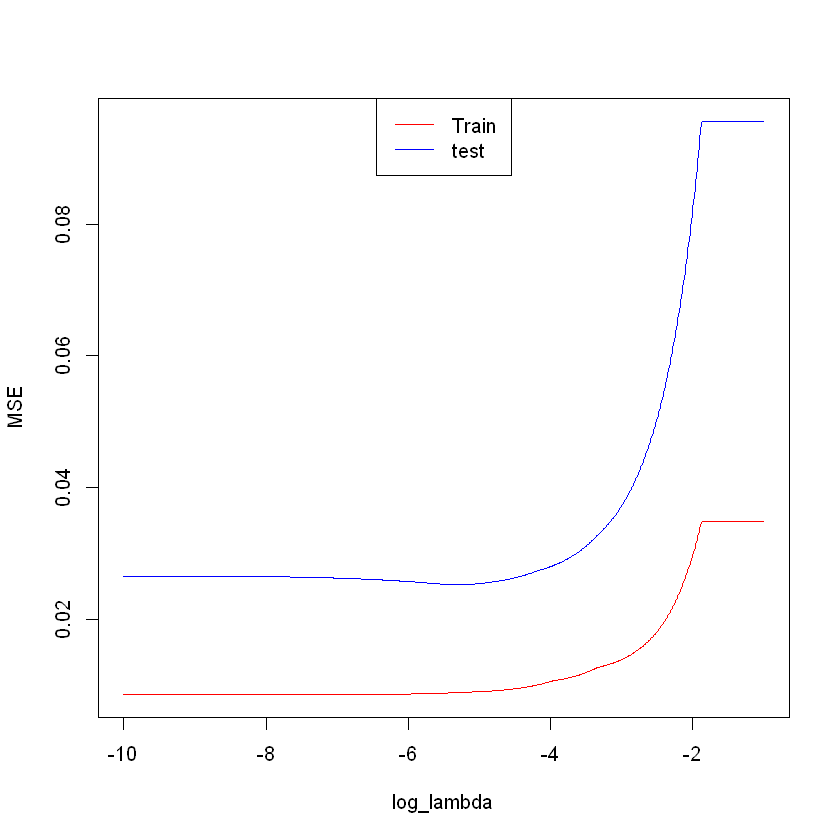

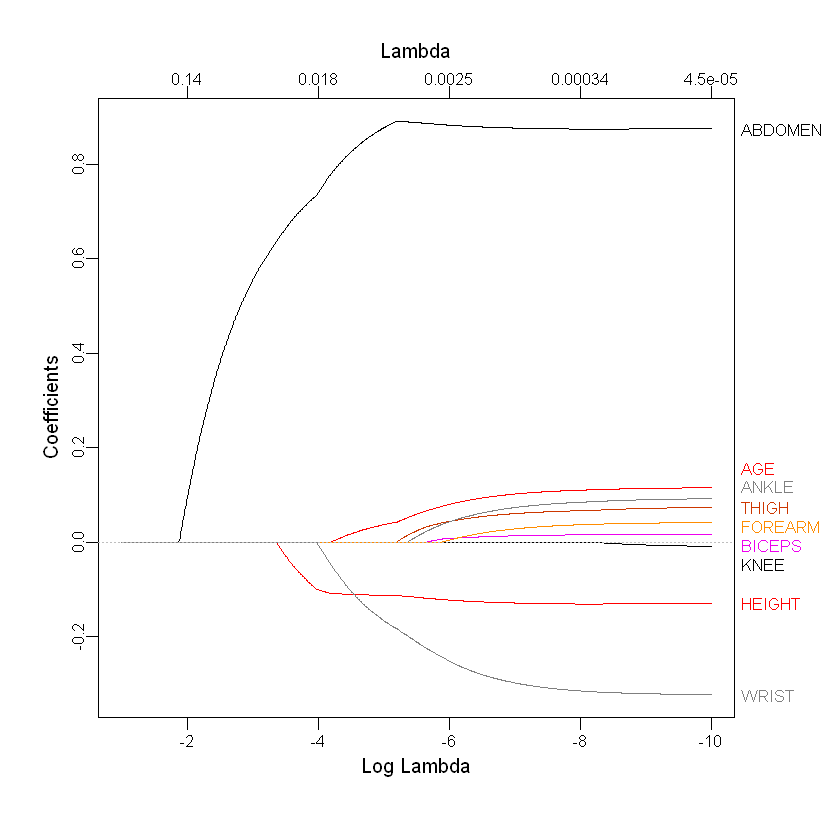

In [38]:
#Training lasso reg and select a best lambda
log_lambda_range <- seq(-10,-1,0.01)
MSE_train=c()
MSE_test = c()
for(log_lambda in log_lambda_range){
  fit.lasso <- glmnet(x=model.matrix(~.,train_norm[,-1]), y=train_norm[,1],
                      family="gaussian", alpha=1, lambda = exp(log_lambda))
  y_pred <- predict(fit.lasso, newx = model.matrix(~.,train_norm[,-1]))
  train_error = y_pred - train_norm[,1]
  MSE_train <- c(MSE_train, mean(train_error^2))
  y_pred <- predict(fit.lasso, newx = model.matrix(~.,test_norm[,-1]))
  test_error = y_pred - test_norm[,1]
  MSE_test = c(MSE_test, mean(test_error^2))
}
#Plot MSE v.s lmabda
plot(log_lambda_range, MSE_train, col = 'red', type="line", xlab = "log_lambda",ylab="MSE",
     ylim=c(min(c(MSE_train,MSE_test)),max(c(MSE_train,MSE_test))))
lines(log_lambda_range, MSE_test, col = "blue", type="line")
legend("top", legend = c("Train", "test"), col = c("red","blue"), lty=1)
#Plot the coefficients trace plot
model <- glmnet(x=model.matrix(~.,train_norm[,-1]), y=train_norm[,1],
                family="gaussian", alpha=1, lambda = exp(log_lambda_range))
plotmo::plot_glmnet(model)

Then we check how MSE behave when using crossvalidation. The following plot shows that it donot have a large deviation when doing 10-folds crossvalidation. Take both MSE and model complexity into consideration, we choose $\lambda=log(-4)$ as the final Lasso model.

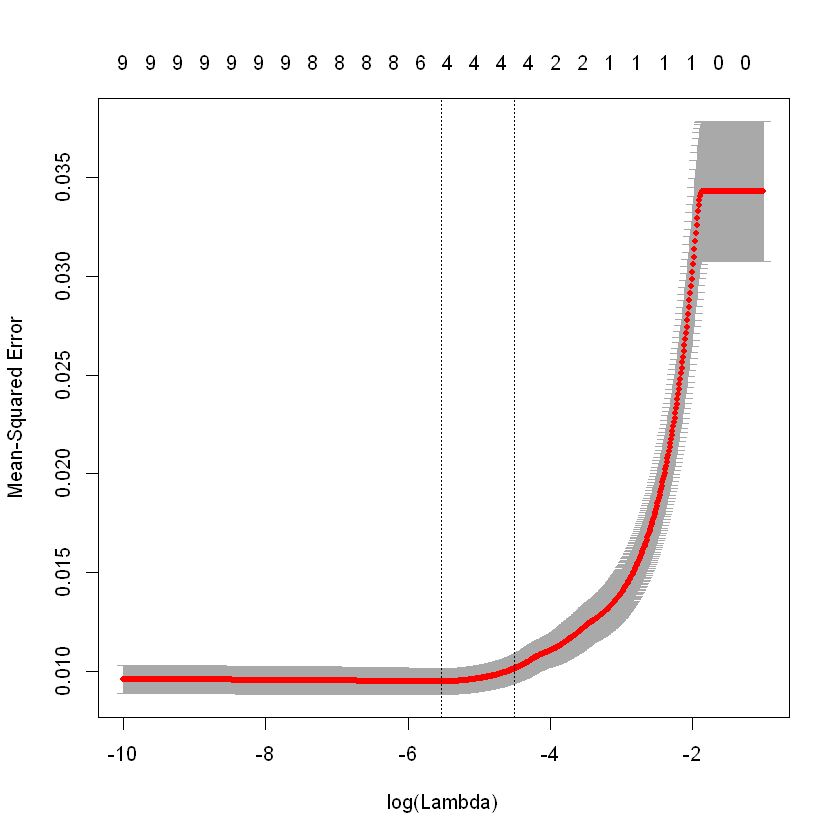

In [39]:
#cross validation model on the whole dataset
body_norm = normalization(BodyFat)
cv_model = cv.glmnet(x=model.matrix(~.,body_norm[,-1]), y=body_norm[,1],
                     family="gaussian", alpha=1, lambda = exp(log_lambda_range),
                     nfolds=10)
plot(cv_model)

We fit the lasso model on the whole dataset with $\lambda=log(-4)$. When we check the residuals, it shows some patterns. The model is not fitted well. The residuals stll contains lots of information. We also try differenct $\lambda$. The model does not fitted well until $\lambda>log(-6)$. But we have almost 8 variables when $\lambda$ reaches $log(-6)$. That's not an ideal model.
In summary, the Lasso model is not suitable for it.

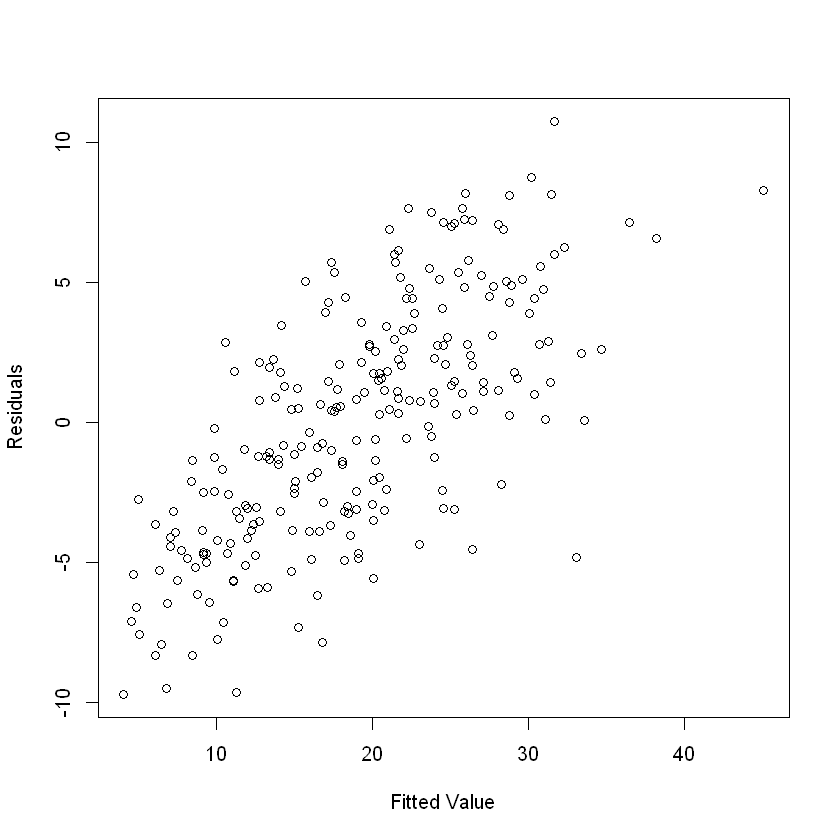

In [42]:
body_norm <- normalization(BodyFat)
model <- glmnet(x=model.matrix(~.,body_norm[,-1]), y=body_norm[,1],
             family="gaussian", alpha=1, lambda = exp(-4))
BodyFat_y <- predict(model, newx =  model.matrix(~.,body_norm[,-1])) 
BodyFat_y <- unnormalization(BodyFat$BODYFAT,BodyFat_y)
BodyFat_error <- BodyFat[,1]-t(BodyFat_y)
plot(BodyFat$BODYFAT,BodyFat_error,ylab = "Residuals",xlab="Fitted Value")

The all possible regression (APR) is a method to find the best subset of all features, but it is computationally expensive. Stepwise regression is a method of fitting regression models in which the choice of predictive variables is carried out by an automatic procedure.$^{[2]}$ We first try the stepwise regression with AIC.<br>
We tried forward, backward and Bidirectional elimination. All these models retain too much features. And these features have large VIF, which means they are strongly linear correlated. Thus we try a stronger penalty: BIC.

In [27]:
setwd("C://Doc/19spring/STAT628/Module1")
rm(list=ls())
#data cleaning
BodyFat = read.table("BodyFat.csv", sep = ",", header = T)
BodyFat = BodyFat[,-1]
BodyFat = BodyFat[,-2]
BodyFat$HEIGHT[42] <- 69.5
BodyFat$WEIGHT[221] <- 173.25
BodyFat$WEIGHT[163] <- 164.25
# BodyFat <- BodyFat[-c(182,172,39),]

full.model <- lm(BODYFAT ~., data = BodyFat)
reduce.model <- lm(BODYFAT~1,data=BodyFat)
# Stepwise regression model
step.model <- MASS::stepAIC(full.model, direction = "both", 
                      trace = F,scope=list(upper=full.model,lower=reduce.model))
for.model <- MASS::stepAIC(reduce.model, direction = "forward", 
                      trace = F,scope=list(upper=full.model,lower=reduce.model))
back.model <- MASS::stepAIC(full.model, direction = "backward", 
                      trace = F)
summary(step.model)
summary(for.model)
summary(back.model)
car::vif(step.model)
# step.model <- MASS::stepAIC(full.model, direction = "both", 
#                       trace = F,scope=list(upper=full.model,lower=reduce.model)
#                            ,k=log(nrow(BodyFat)-1))
# for.model <- MASS::stepAIC(reduce.model, direction = "forward", 
#                       trace = F,scope=list(upper=full.model,lower=reduce.model)
#                           ,k=log(nrow(BodyFat)-1))
# back.model <- MASS::stepAIC(full.model, direction = "backward", 
#                       trace = F,
#                            k=log(nrow(BodyFat)-1))
# summary(step.model)
# summary(for.model)
# summary(back.model)


Call:
lm(formula = BODYFAT ~ AGE + WEIGHT + HEIGHT + ADIPOSITY + NECK + 
    ABDOMEN + HIP + THIGH + FOREARM + WRIST, data = BodyFat)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.6345 -2.7350 -0.2834  2.7571  9.2898 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -124.03067   47.52545  -2.610  0.00963 ** 
AGE            0.06684    0.02835   2.357  0.01921 *  
WEIGHT        -0.37285    0.13009  -2.866  0.00452 ** 
HEIGHT         1.54182    0.67584   2.281  0.02340 *  
ADIPOSITY      2.25716    0.94389   2.391  0.01756 *  
NECK          -0.41425    0.20944  -1.978  0.04908 *  
ABDOMEN        0.82045    0.07893  10.394  < 2e-16 ***
HIP           -0.23152    0.12812  -1.807  0.07200 .  
THIGH          0.31260    0.12101   2.583  0.01037 *  
FOREARM        0.41375    0.17413   2.376  0.01828 *  
WRIST         -1.46110    0.46658  -3.132  0.00195 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 3.9


Call:
lm(formula = BODYFAT ~ ABDOMEN + WEIGHT + WRIST + FOREARM + NECK + 
    AGE + THIGH + HIP, data = BodyFat)

Residuals:
    Min      1Q  Median      3Q     Max 
-10.079  -2.730  -0.166   2.667   9.438 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -20.84753   10.55583  -1.975  0.04940 *  
ABDOMEN       0.88204    0.06653  13.258  < 2e-16 ***
WEIGHT       -0.08820    0.03590  -2.457  0.01472 *  
WRIST        -1.39456    0.46830  -2.978  0.00320 ** 
FOREARM       0.48927    0.17236   2.839  0.00491 ** 
NECK         -0.42819    0.20652  -2.073  0.03919 *  
AGE           0.05910    0.02833   2.086  0.03800 *  
THIGH         0.28675    0.11925   2.405  0.01694 *  
HIP          -0.18109    0.12662  -1.430  0.15395    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 3.958 on 243 degrees of freedom
Multiple R-squared:  0.7475,	Adjusted R-squared:  0.7392 
F-statistic: 89.94 on 8 and 243 DF,  p-value: < 2.2e-1


Call:
lm(formula = BODYFAT ~ AGE + WEIGHT + HEIGHT + ADIPOSITY + NECK + 
    ABDOMEN + HIP + THIGH + FOREARM + WRIST, data = BodyFat)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.6345 -2.7350 -0.2834  2.7571  9.2898 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -124.03067   47.52545  -2.610  0.00963 ** 
AGE            0.06684    0.02835   2.357  0.01921 *  
WEIGHT        -0.37285    0.13009  -2.866  0.00452 ** 
HEIGHT         1.54182    0.67584   2.281  0.02340 *  
ADIPOSITY      2.25716    0.94389   2.391  0.01756 *  
NECK          -0.41425    0.20944  -1.978  0.04908 *  
ABDOMEN        0.82045    0.07893  10.394  < 2e-16 ***
HIP           -0.23152    0.12812  -1.807  0.07200 .  
THIGH          0.31260    0.12101   2.583  0.01037 *  
FOREARM        0.41375    0.17413   2.376  0.01828 *  
WRIST         -1.46110    0.46658  -3.132  0.00195 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 3.9

AGE     WEIGHT     HEIGHT  ADIPOSITY       NECK    ABDOMEN        HIP 
  2.077374 237.364833  50.608943 192.922508   4.217412  11.786768  13.706641 
     THIGH    FOREARM      WRIST 
  6.566458   2.014427   3.087190

[1] https://insightr.wordpress.com/2017/06/14/when-the-lasso-fails/ <br>
[2]  Efroymson,M. A. (1960) "Multiple regression analysis," Mathematical Methods for Digital Computers, Ralston A. and Wilf,H. S., (eds.), Wiley, New York.
